In [158]:
from typing import List, Dict, Any, Literal, Annotated

from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI 
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain.schema import HumanMessage, AIMessage
from langgraph.types import interrupt, Command

from pydantic import BaseModel

In [159]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [160]:
class AskMoreDetails(BaseModel):
  """Peça por mais informações para o usuário"""
  question: str

receptionist_tools = [AskMoreDetails]

In [161]:
llm_receptionist = ChatOpenAI(model="gpt-4o-mini")

receptionist_prompt = ChatPromptTemplate.from_messages([
  ("system", """
# Função
Você é um assistente de compras online. 
# Tarefa
- Você é responsavel por atender o usuário, perguntando o básico sobre o que ele deseja comprar. 
- Faça no máximo 1 pergunta, o mais completa possível, para clarificar o que o usuário deseja.
  - Essa pergunta deve ter o seguinte formato: "Ao comprar um <produto>, é importante levar em consideração <caracteristicas>. Com isso, preciso que responda as seguintes perguntas: <perguntas>"
"""),
  MessagesPlaceholder("messages")
])

def receptionist(state: State):
  message = (receptionist_prompt | llm_receptionist.bind_tools(receptionist_tools)).invoke(state["messages"])
  print(f"RECEPTIONIST -> {message}")
  assert len(message.tool_calls) <= 1
  return {"messages": [message]}

graph_builder.add_node("receptionist", receptionist)

In [162]:
def ask_human(state):
  print("ASK_HUMAN")
  tool_call = state["messages"][-1].tool_calls[0]
  
  tool_call_id = tool_call["id"]
  question = tool_call["args"]["question"]
  print(f"question {question}")

  human_response = interrupt(question)
  tool_message = {"tool_call_id": tool_call_id, "type": "tool", "content": human_response}
  print(f"tool_message {tool_message}")

  return {"messages": [tool_message]}

graph_builder.add_node("ask_human", ask_human)

In [163]:
llm_fake_web_search = ChatOpenAI(model="gpt-4o-mini")

fake_web_search_prompt = ChatPromptTemplate.from_messages([
  ("system", "Você simula buscas na internet. Ao receber a query do usuário retorna informações relacionadas ao assunto buscado, contendo o link da página e um resumo de seu conteúdo"),
  MessagesPlaceholder("messages")
])

@tool
def web_search(query: str) -> str:
  """Busca na internet por mais informações"""
  return (fake_web_search_prompt | llm_fake_web_search).invoke([HumanMessage(query)])

tools = [web_search]
tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

In [164]:
llm_researcher = ChatOpenAI(model="gpt-4o-mini")

researcher_prompt = ChatPromptTemplate.from_messages([
  ("system", "Você é um assistente de compras online, responsavel por buscar produtos na internet conforme solicitado pelo usuário"),
  MessagesPlaceholder("messages")
])

def researcher(state: State):
  message = (researcher_prompt | llm_researcher.bind_tools(tools)).invoke(state["messages"])
  print(f"RESEARCHER -> {message}")
  return {"messages": [message]}

graph_builder.add_node("researcher", researcher)

In [165]:
llm_analyst = ChatOpenAI(model="gpt-4o-mini")

analyst_prompt = ChatPromptTemplate.from_messages([
  ("system", "Você é um assistente de compras online, responsavel analisar produtos e selecionar os mais relevantes de acordo com os dados recebidos."),
  MessagesPlaceholder("messages")
])

def analyst(state: State):
  message = (analyst_prompt | llm_analyst).invoke(state["messages"])
  print(f"ANALYST -> {message}")
  return {"messages": [message]}

graph_builder.add_node("analyst", analyst)

In [166]:
llm_product_reviewer = ChatOpenAI(model="gpt-4o-mini")

product_reviewer_prompt = ChatPromptTemplate.from_messages([
  ("system", "Você é um assistente de compras online, responsavel por comparar produtos pré-selecionados por um analista afim de ajudar o usuário na sua decisão de compra."),
  MessagesPlaceholder("messages")
])

def product_reviewer(state: State):
  # converted_messages = [
  #   HumanMessage(content=msg.content) if isinstance(msg, AIMessage) and hasattr(msg, "tool_calls") and msg.tool_calls
  #   else AIMessage(content=msg.content) if isinstance(msg, HumanMessage)
  #   else msg
  #   for msg in state["messages"]
  # ]

  # state["messages"] = converted_messages
  message = (product_reviewer_prompt | llm_product_reviewer).invoke(state["messages"])
  print(f"PRODUCT_REVIEWER -> {message}")
  
  return {"messages": [message]}

graph_builder.add_node("product_reviewer", product_reviewer)

In [167]:
def need_more_details(state: State) -> Literal["ask_human", "researcher"]:
  """Define se precisa pedir mais detalhes para o usuário"""
  print("NEED_MORE_DETAILS")
  last_message = state["messages"][-1]
  return "ask_human" if last_message.tool_calls else "researcher"


graph_builder.add_edge(START, "receptionist")
graph_builder.add_conditional_edges(
  "receptionist",
  need_more_details,
)
graph_builder.add_edge("ask_human", "researcher")
graph_builder.add_conditional_edges(
  "researcher",
  tools_condition,
)
graph_builder.add_edge("tools", "analyst")
graph_builder.add_edge("analyst",  "product_reviewer")
graph_builder.add_edge("product_reviewer", END)

In [168]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

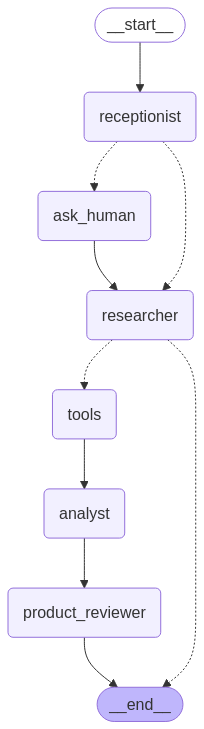

In [169]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  # This requires some extra dependencies and is optional
  pass

In [170]:
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input):
  events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]} if isinstance(user_input, str) else user_input,
    config,
    stream_mode="values"
  )

  last_message = ""
  for event in events:
    print(f"event -> {event}")
    
    if "messages" in event:
      last_message = event["messages"][-1]
      last_message.pretty_print()
  
  if hasattr(last_message, "tool_calls") and last_message.tool_calls:
    question = last_message.tool_calls[0]["args"]["question"]
    human_response = input(f"{question}\nUser: ")
    if human_response.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      return
    command = Command(resume=human_response)
    stream_graph_updates(command)


try:
  user_input = input("User: ")
  if user_input.lower() in ["quit", "exit", "q"]:
    print("Goodbye!")
  else:
    stream_graph_updates(user_input)
    print("AFTER stream_graph_updates")
except Exception as e:
  print("EXCEPT:")
  print(e)
  

event -> {'messages': [HumanMessage(content='Quero comprar um teclado', additional_kwargs={}, response_metadata={}, id='f8251a0d-9c47-44d7-a07a-1df39edd1e02')]}
================================ Human Message =================================

Quero comprar um teclado
RECEPTIONIST -> content='' additional_kwargs={'tool_calls': [{'id': 'call_jDdK7o8WBHWffLfjDz1ocaVl', 'function': {'arguments': '{"question":"Ao comprar um teclado, é importante levar em consideração o tipo (mecânico ou membrana), o layout (ABNT2, US, etc.), se possui iluminação, e a presença de teclas adicionais. Com isso, preciso que responda as seguintes perguntas: que tipo de teclado você prefere, qual layout você precisa, quer que tenha iluminação e se precisa de teclas adicionais?"}', 'name': 'AskMoreDetails'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 159, 'total_tokens': 253, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audi